<a href="https://colab.research.google.com/github/NaphatPRM/CIS5450_Final_Project/blob/main/CIS_5450_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CIS 5450 Final Project: Phishing URL Detection**

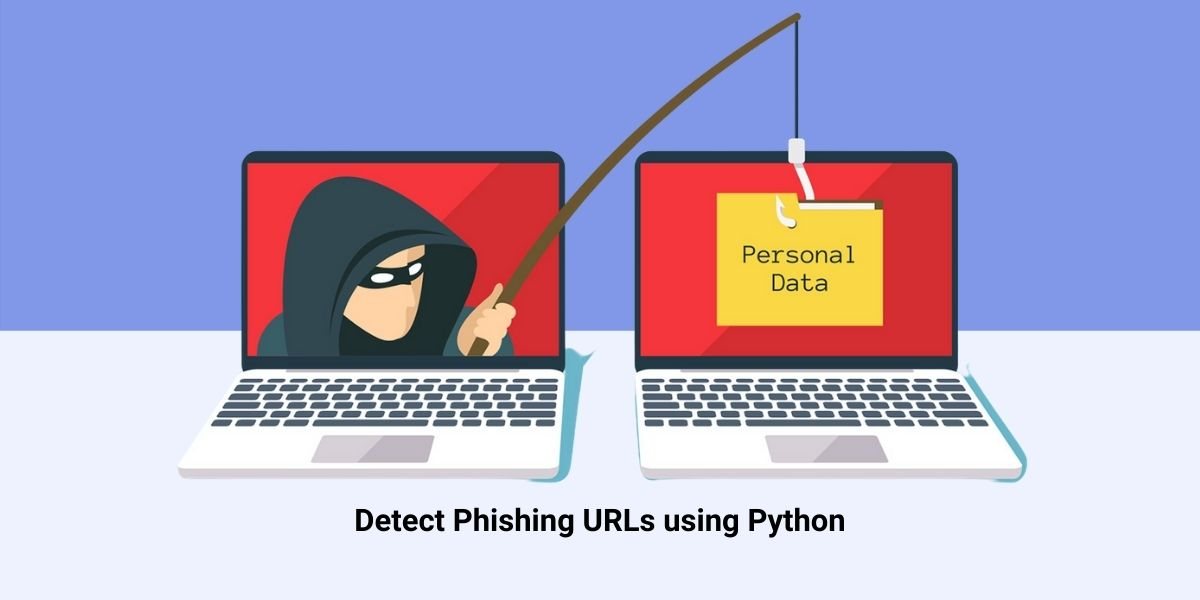

## **1. Motivation for the project**

Our group is interesting because phishing is a very critical cyber security concern nowadays, which most of us have experienced. This research could also be used by some web surveillance/security algorithm to filter out suspicious links before it gets to humans.

## **2. Expected Challenges**

The anticipated challenges and obstacles we may face with this project is that this area is very new for us and we need to be familiar with what the features are describing. We need to select which features are relevant for starting out and do data wrangling to use in our models. If the current features provided in the dataset don't predict phishing effectively, we will need to build deeper domain knowledge in order to create/extract additional features that could improve accuracy.


In [ ]:
!pip install ucimlrepo
!pip install pydotplus

# **Part 1 : Data Exploration**

Our group first trying to understand the notation of the data and what each column represents. For this part, we first doing a research on the metadata of this dataset, which is written in the paper "[PhiUSIIL: A diverse security profile empowered phishing URL detection framework based on similarity index and incremental learning](https://tinyurl.com/PhiUSIIL-phishing-URL-paper)".

From this paper, we learn that the features could be divided into groups as follow:

1. **URL Features** :

- `URL` : The URL of the website
- `URLLength` : Lenght of the website URL
- `Domain` : The domain name. Mainly a URL without https://
- `DomainLength` : The length of the domain
- `IsDomainIP` : Whether the domain is the IP address (1-Yes)
- `TLD`: Top Level Domain - The last part of the domain name
- `NoOfSubDomain` : Subdomain is part of URL that appears before
domain name. This field determines how many subdomain contains in the URL.
- `TLDLegitimateProb` : The probabiliy that the TLD is legitimate. The dataset calculate this by finding the probability of the legitimate website having that TLD among the list of 10 million legitimate website.
- `URLCharProb` : This dataset first calculate the probability that the letter would appear based on the list of legitimate websites, then averaging them for each URL entries.
- `TLDLength` : Length of the TLD.
- `HasObfuscation` : Whether the URL has an obfuscated character or not. Obfuscated character is defined as the letter that is represented as a combination of percent `%` and number instead (such as `%20`)
- `NoOfObfuscatedChar` : Number of obfuscated characters
- `ObfuscationRatio` : Ratio between number of obfuscated character and the length of the URL
- `NoOfLettersInURL` : Number of character in the URL
- `LetterRatioInURL` : Ratio between number of characters and the length of the URL
- `NoOfDegitsInURL` : Number of number digit in the URL
- `DegitRatioInURL` : Ratio between number of digits and the length of the URL
- `NoOfEqualsInURL` : Number of an equal mark `=` in the URL
- `NoOfQMarkInURL` : Number of a question mark `?` in the URL
- `NoOfAmpersandInURL` : Number of an ampersand mark `&` in the URL
- `NoOfOtherSpecialCharsInURL` : Number of other special characters in the URL
- `SpacialCharRatioInURL` : Ratio between number of other special characters and the length of the URL
- `IsHTTPS` : Whether this URL is a HTTPS (Hypertext transfer protocol secure) URL or not.

2. **HTML Features** :

Beyond the URL itself, the content after direct from the URL could also determine the probability of the website being a phishing URL. In this dataset, they consider the feature as follow.

- `LineOfCode`
- `LargestLineLength`
- `HasTitle` : Whether there is a page title provided (1 - True)
- `Title` : The title of the page if provided
- `DomainTitleMatchScore` : The correlation between the information in the website and the Domain Name. 100 as the perfectly correlated, 0 for uncorrelated.
- `URLTitleMatchScore` : The correlation between the information in the website and the URL Name. 100 as the perfectly correlated, 0 for uncorrelated.
- `HasFavicon` : Whether the website having a favicon appear when search
- `Robots`
- `IsResponsive` : Whether the website is responsive to the device used to open the website (change the CSS based on the phone/computer)
- `NoOfURLRedirect` : Number of redirect from the
- `NoOfSelfRedirect`
- `HasDescription` : Whether there is a description of the website in the metadata or not.
- `NoOfPopup` : Number of the Pop up in the websites
- `NoOfiFrame` : Number of the iFrame (or inline frame) in the website
- `HasExternalFormSubmit` : Whether the website has a form submitting to the external URL or not
- `HasSocialNet` : Whether the website has a social networking information on the website or not.
- `HasSubmitButton`
- `HasHiddenFields`
- `HasPasswordField`
- `Bank`, `Pay` and `Crypto` : Determine whether the website contains the paying method (whether it's through Bank Transfer, Credit Card, or Crypto)
- `HasCopyrightInfo` : Whether there is a copyright information on the website or not.
- `NoOfImage` : Number of images in the website.
- `NoOfCSS`
- `NoOfJS`
- `NoOfSelfRef` : Number of the hyperlinks navigating to itself in the website
- `NoOfEmptyRef` : Number of the hyperlinks navigating to the empty page in the website
- `NoOfExternalRef` : Number of the hyperlinks navigating to the external website in the website

3. **Derived Features** :

These values are derived

- `URLSimilarityIndex` : The Similarity index between the URL and the list of URL in top 10 million legitimate websites downloaded from Open PageRank Initiative.
- `CharContinuationRate` : Indicates how a URL contains the alphabet, digit, or special characters. Calculated by finding the longest sequence of pure alphabet, digit, or special characters divided with the entire length.

In [ ]:
# Import All library
## Data Download
from ucimlrepo import fetch_ucirepo
## Data Exploration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Feature Selection Process
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif

## Machine Learning Model + Visualization
### Model Selection
from sklearn.model_selection import train_test_split, GridSearchCV
### Logistic Regression
from sklearn.linear_model import LogisticRegression
### Decision Tree
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import pydotplus
import graphviz
from IPython.display import Image

In [ ]:
# Fetching Phishing URL Dataset
phiusiil_phishing_url_website = fetch_ucirepo(id=967)

# Divide the dataset into the features (X) and labels (y)
X = phiusiil_phishing_url_website.data.features
y = phiusiil_phishing_url_website.data.targets

# Data Inspection : Connect X and Y
df = pd.concat([X, y], axis=1)

In [ ]:
## Data Inspection
## What have done so far
## y.describe()
df[["URL", "URLTitleMatchScore", "label"]].sort_values(by='URLTitleMatchScore', ascending=True).head()

,URL,URLTitleMatchScore,label
0,https://www.southbankmosaics.com,0.0,1
128087,https://maildinshaakckjnw55.firebaseapp.com/,0.0,0
128090,https://dev-seguridad-itauweb-pyg.pantheonsite...,0.0,0
128092,https://www.amaczon-co-jp.amazccn.tqybfw.top/a...,0.0,0
128097,http://white-band-7524.tb4iugnz.workers.dev/,0.0,0


In [ ]:
X.describe()

,URLLength,DomainLength,IsDomainIP,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,TLDLength,NoOfSubDomain,HasObfuscation,...,Bank,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef
count,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,...,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000
mean,34.573095,21.470396,0.002706,78.430778,0.845508,0.260423,0.055747,2.764456,1.164758,0.002057,...,0.127089,0.237007,0.023474,0.486775,26.075689,6.333111,10.522305,65.071113,2.377629,49.262516
std,41.314153,9.150793,0.051946,28.976055,0.216632,0.251628,0.010587,0.599739,0.600969,0.045306,...,0.333074,0.425247,0.151403,0.499826,79.411815,74.866296,22.312192,176.687539,17.641097,161.027430
min,13.000000,4.000000,0.000000,0.155574,0.000000,0.000000,0.001083,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,23.000000,16.000000,0.000000,57.024793,0.680000,0.005977,0.050747,2.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,27.000000,20.000000,0.000000,100.000000,1.000000,0.079963,0.057970,3.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,8.000000,2.000000,6.000000,12.000000,0.000000,10.000000
75%,34.000000,24.000000,0.000000,100.000000,1.000000,0.522907,0.062875,3.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,29.000000,8.000000,15.000000,88.000000,1.000000,57.000000
max,6097.000000,110.000000,1.000000,100.000000,1.000000,0.522907,0.090824,13.000000,10.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,8956.000000,35820.000000,6957.000000,27397.000000,4887.000000,27516.000000


In [ ]:
X.describe(include='all')

,URL,URLLength,Domain,DomainLength,IsDomainIP,TLD,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,...,Bank,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef
count,235795,235795.000000,235795,235795.000000,235795.000000,235795,235795.000000,235795.000000,235795.000000,235795.000000,...,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000
unique,235370,NaN,220086,NaN,NaN,695,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,https://disclosepack.myportfolio.com/,NaN,ipfs.io,NaN,NaN,com,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,2,NaN,1197,NaN,NaN,112554,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,34.573095,NaN,21.470396,0.002706,NaN,78.430778,0.845508,0.260423,0.055747,...,0.127089,0.237007,0.023474,0.486775,26.075689,6.333111,10.522305,65.071113,2.377629,49.262516
std,NaN,41.314153,NaN,9.150793,0.051946,NaN,28.976055,0.216632,0.251628,0.010587,...,0.333074,0.425247,0.151403,0.499826,79.411815,74.866296,22.312192,176.687539,17.641097,161.027430
min,NaN,13.000000,NaN,4.000000,0.000000,NaN,0.155574,0.000000,0.000000,0.001083,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,23.000000,NaN,16.000000,0.000000,NaN,57.024793,0.680000,0.005977,0.050747,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,NaN,27.000000,NaN,20.000000,0.000000,NaN,100.000000,1.000000,0.079963,0.057970,...,0.000000,0.000000,0.000000,0.000000,8.000000,2.000000,6.000000,12.000000,0.000000,10.000000
75%,NaN,34.000000,NaN,24.000000,0.000000,NaN,100.000000,1.000000,0.522907,0.062875,...,0.000000,0.000000,0.000000,1.000000,29.000000,8.000000,15.000000,88.000000,1.000000,57.000000


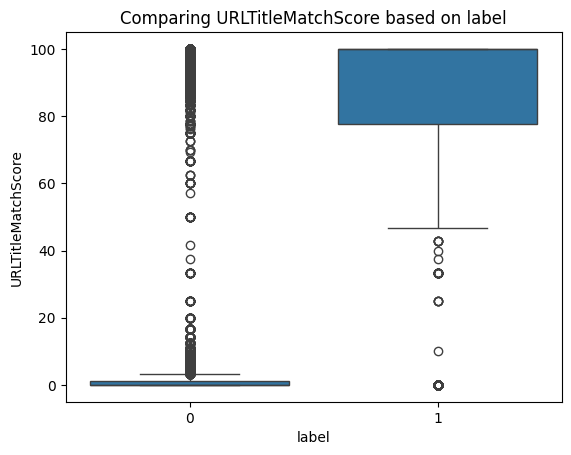

In [ ]:
## EDA : Inspect more on the value and the label directly
sns.boxplot(x='label', y='URLTitleMatchScore', data=df)
plt.title("Comparing URLTitleMatchScore based on label")
plt.show()

<Axes: xlabel='NoOfPopup', ylabel='NoOfExternalRef'>

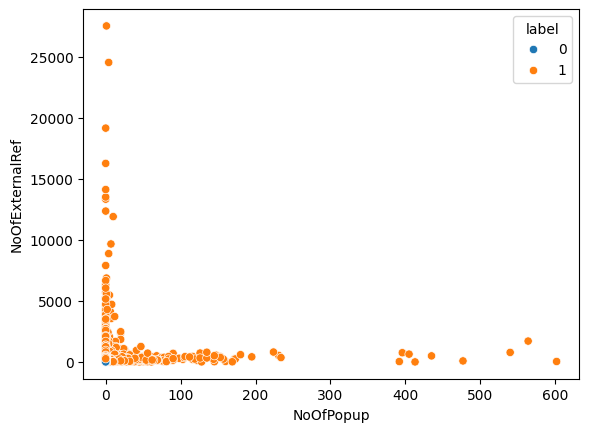

In [ ]:
## EDA 2 : Scatter Plot comparing data from two groups
sns.scatterplot(x='NoOfPopup', y='NoOfExternalRef', hue='label', data=df)

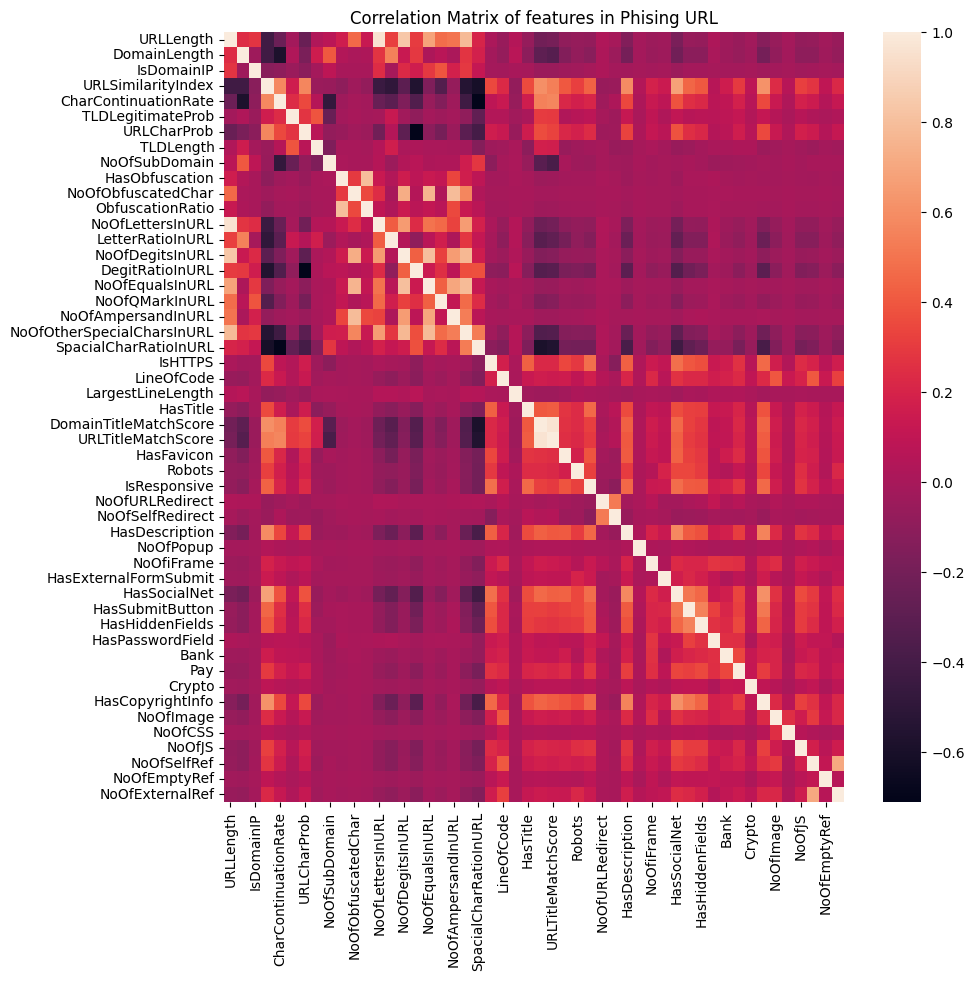

In [ ]:
# Check the correlation between the features
plt.figure(figsize=(10,10))
sns.heatmap(X_numerical.corr())
plt.title('Correlation Matrix of features in Phising URL')
plt.show()

In [ ]:
## Convert the correlation into the dataset for an easier observation
df_corr = X_numerical.corr().abs()

## Step 1 : Convert it into a stack of two variables
so = df_corr.unstack()

## Step 2 : Convert it into the Pandas DataFrame
df_from_corr = pd.DataFrame(so, columns=['Correlation'])

## Step 3 : Convert the inaccessible index into teo columns of variables
df_from_corr['index1'] = df_from_corr.index
df_from_corr['index2'] = df_from_corr['index1'].apply(lambda x: x[1])
df_from_corr['index1'] = df_from_corr['index1'].apply(lambda x: x[0])

## Step 4 : Sort by Correlation and check the value appropriate for the analysis
df_from_corr = df_from_corr.sort_values('Correlation', ascending=False)
df_from_corr = df_from_corr.drop_duplicates(subset=['Correlation'])
df_from_corr_select = df_from_corr[df_from_corr['Correlation'] < 0.8]
df_from_corr_select.reset_index(drop=True, inplace=True)
df_from_corr_select

,Correlation,index1,index2
0,0.798791,HasObfuscation,ObfuscationRatio
1,0.786451,NoOfAmpersandInURL,NoOfObfuscatedChar
2,0.784654,NoOfEqualsInURL,NoOfOtherSpecialCharsInURL
3,0.782582,URLLength,NoOfOtherSpecialCharsInURL
4,0.767477,NoOfDegitsInURL,NoOfOtherSpecialCharsInURL
...,...,...,...
1216,0.000354,IsDomainIP,NoOfObfuscatedChar
1217,0.000310,LargestLineLength,NoOfEmptyRef
1218,0.000221,NoOfSubDomain,NoOfPopup
1219,0.000201,NoOfAmpersandInURL,HasTitle


## **Part 2 : Data Preprocessing**

In [ ]:
## Data Preprocessing : Converting X into the numerical values to perform the models
X_numerical = X[list(X.describe().columns)]
X_numerical.head()

,URLLength,DomainLength,IsDomainIP,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,TLDLength,NoOfSubDomain,HasObfuscation,...,Bank,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef
0,31,24,0,100.0,1.000000,0.522907,0.061933,3,1,0,...,1,0,0,1,34,20,28,119,0,124
1,23,16,0,100.0,0.666667,0.032650,0.050207,2,1,0,...,0,0,0,1,50,9,8,39,0,217
2,29,22,0,100.0,0.866667,0.028555,0.064129,2,2,0,...,0,0,0,1,10,2,7,42,2,5
3,26,19,0,100.0,1.000000,0.522907,0.057606,3,1,0,...,0,1,1,1,3,27,15,22,1,31
4,33,26,0,100.0,1.000000,0.079963,0.059441,3,1,0,...,1,1,0,1,244,15,34,72,1,85


## **Part 3 : Feature Selection**

After performing an exploration on what each feature does and the correlation between each of them. We now consider the feature that should be used to perform the model training. In this process, we are thinking between two main approach:
1. Principal Component Analysis (PCA) : This is a technique that reduce high number of correlated features to a lower number of uncorrelated features. Our group uses the similar principle with the class through using the

2. Using the idea of "Feature Selection" model from the sklearn (but it maybe exceeding the scope of the class)

In [ ]:
## Using the PCA Method
## Benefits : Filter to a low-correlated features
## Disadvantage : Hard to interpret
pca = PCA(n_components=20)
X_pca = pca.fit_transform(X_numerical)
X_pca.shape

(235795, 20)

In [ ]:
## Using the Feature Selection Method
## Benefits : Easier for the interpretability since it uses only the existing features
## Disadvantage : Could remain a highly-correlated features (may require manual selection)
X_new = SelectKBest(f_classif, k=20).fit_transform(X_numerical, y)
X_new.shape

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(235795, 20)

# **Part 4 : Model Selection**

After preprocessing the data, we decide what model would be appropriate to create the best model. In this case, we decide to consider the following models:

1. A Decision tree (or even an Ensemble Tree)
2. Logistic Regression


In [ ]:
## Data Train and Test Split
X_train, X_test, y_train, y_test = train_test_split(X_numerical, y, test_size=0.3, random_state=42)

In [ ]:
# 1. Decision Tree Performance with the Cross Validation
# Step 1 : Initiate the Decision Tree
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train, y_train)
precision_score(y_test, clf.predict(X_test))

1.0

In [ ]:
# 2. Decision Tree with GridSearchCV through Feature Selection
param_grid = {
	'C': [0.01, 0.1, 0.5, 1, 10, 100],
	'gamma': [1, 0.75, 0.5, 0.25, 0.1, 0.01, 0.001],
	'kernel': ['rbf', 'poly', 'linear']
}

grid = GridSearchCV(DecisionTreeClassifier(random_state=0), param_grid, refit=True, verbose=1, cv=5)
grid.fit(X_train, y_train)
best_params = grid.best_params_
print(f"Best params: {best_params}")

svm_clf = DecisionTreeClassifier(**best_params)
svm_clf.fit(X_train, y_train)

print_score(svm_clf, X_train, y_train, X_test, y_test, train=True)
print_score(svm_clf, X_train, y_train, X_test, y_test, train=False)

Fitting 5 folds for each of 126 candidates, totalling 630 fits


ValueError: Invalid parameter 'C' for estimator DecisionTreeClassifier(random_state=0). Valid parameters are: ['ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'monotonic_cst', 'random_state', 'splitter'].

In [ ]:
# Tree Visualization
dot_data = export_graphviz(clf, out_file=None, feature_names=X_train.columns, class_names=["No","Yes"], filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)
img = Image(graph.create_png())
img

In [ ]:
## Logistic Regression

# Step 1 : Making the Logistic Regression model
log_model = LogisticRegression()
log_model.fit(X_train, y_train)
y_pred = log_model.predict(X_test)

# Step 2 : Checking the result based on the metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)